In [3]:
%matplotlib inline
import theano
import pymc3 as pm
import sklearn
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from warnings import filterwarnings
filterwarnings('ignore')
sns.set_style('white')

from sklearn.preprocessing import scale
from sklearn.model_selection import train_test_split
from sklearn.metrics import plot_roc_curve
from sklearn.metrics import auc
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score


from scipy.stats import mode, chisquare
import pandas as pd

In [4]:
theano.config.floatX = 'float32'

In [5]:
df = pd.read_csv('fraude_scaled_imputed.tsv', sep='\t')
df['Pais'] = [1 if x.upper() == 'AR' else 0 for x in df.Pais]
MONTO = df.Monto.values
df.head()

A          B             C         D         E         F         G  \
0 -0.282654   8.368636  50256.521349 -0.097259 -0.282124 -0.160827 -0.087519   
1 -0.282654   8.368636  29013.521349 -0.097259 -0.282124 -0.160827 -0.087519   
2 -0.282654   5.368636     91.521349 -0.097259  0.717876 -0.160827 -0.087519   
3  8.717346  14.368636  50268.521349 -0.097259 -0.282124 -0.160827 -0.087519   
4 -0.282654   6.368636   8179.521349 -0.097259 -0.282124 -0.160827 -0.087519   

          H         I         L         M         N        O         P  \
0 -0.094709 -0.174688 -0.651261  1.489673 -1.675367 -0.08078  3.501437   
1 -0.094709 -0.174688 -0.651261 -0.510327 -1.675367 -0.08078  1.501437   
2 -0.094709  0.825312 -0.651261  1.489673 -1.675367 -0.08078  0.501437   
3 -0.094709 -0.174688 -0.651261  1.489673 -1.675367 -0.08078  3.501437   
4 -0.094709 -0.174688 -0.651261 -0.510327 -1.675367 -0.08078 -0.498563   

          Q         R          S      Monto  Pais  Fraude  
0 -0.113563 -0.052192   6.151278   36.92257     0       1  
1 -0.113563 -0.052192  10.561278    7.59257     0       1  
2 -0.113563 -0.052192  85.871278   13.37257     0       1  
3 -0.113563 -0.052192   1.411278   93.08257     0       1  
4 -0.113563 -0.052192  24.861278  134.81257     0       1

#### Funcion de ganancia

In [6]:
def _loss(monto, y_true, y_pred):
    #global idx2amount
    ganancia = monto * 0.25
    if y_pred == 1 and y_true == 1:
        return 0
    elif y_pred == 0 and y_true == 1:
        return -100 #- monto
    elif y_pred == 0 and y_true == 0:
        return 25#ganancia
    elif y_pred == 1 and y_true == 0:
        return -25#- ganancia


def custom_loss_calc(monto_arr, true_array, pred_array):
    return sum(_loss(i, yp, yt) 
               for i, yp, yt in 
               zip(monto_arr, pred_array, true_array)
              )

#### Separo los datos en entrenamiento y test en 70 / 30

In [7]:
X = scale(df.drop('Fraude', axis=1).values)
X = X.astype(theano.config.floatX)
Y = df.Fraude.values.astype(theano.config.floatX)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=.30)

### Funcion constructora de la red

In [8]:
def construct_nn(ann_input, ann_output):
    n_hidden = 8
    
    # inicializo los pesos de modo aleatorio para cada capa
    init_1 = np.random.randn(X.shape[1], n_hidden).astype(theano.config.floatX)
    init_2 = np.random.randn(n_hidden, n_hidden).astype(theano.config.floatX)
    init_out = np.random.randn(n_hidden).astype(theano.config.floatX)
        
    with pm.Model() as neural_network:
        # declaracion de la distribucion de pesos de la entrada a la primer capa Normal
        weights_in_1 = pm.Normal('w_in_1', 0, sd=1, 
                                 shape=(X.shape[1], n_hidden), 
                                 testval=init_1)
        
        # declaracion de la distribucion de pesos de la primer capa a la segunda Normal
        weights_1_2 = pm.Normal('w_1_2', 0, sd=1, 
                                shape=(n_hidden, n_hidden), 
                                testval=init_2)
        
        # declaracion de la distribucion de pesos de la segunda capa a la capa de salida Normal
        weights_2_out = pm.Normal('w_2_out', 0, sd=1, 
                                  shape=(n_hidden,), 
                                  testval=init_out)
        
        # Declaro las funciones de activacion, tanh tanh sig
        act_1 = pm.math.tanh(pm.math.dot(ann_input, 
                                         weights_in_1))
        act_2 = pm.math.tanh(pm.math.dot(act_1, 
                                         weights_1_2))
        act_out = pm.math.sigmoid(pm.math.dot(act_2, 
                                              weights_2_out))
        
        # Clasificacion binaria de salida -> Verosimilitud de Bernoulli
        out = pm.Bernoulli('out', 
                           act_out,
                           observed=ann_output,
                           total_size=Y_train.shape[0] 
                          )
    return neural_network


ann_input = theano.shared(X_train)
ann_output = theano.shared(Y_train)
neural_network = construct_nn(ann_input, ann_output)

In [9]:
from pymc3.theanof import set_tt_rng, MRG_RandomStreams
set_tt_rng(MRG_RandomStreams(42))

#### Ejecuto la inferencia variacional de los posteriori de los pesos y por lo tanto la red

In [10]:
%%time
minibatch_x = pm.Minibatch(X_train, batch_size=32)
minibatch_y = pm.Minibatch(Y_train, batch_size=32)

neural_network_minibatch = construct_nn(minibatch_x, minibatch_y)
with neural_network_minibatch:
    inference = pm.ADVI()
    approx = pm.fit(40000, method=inference)



Average Loss = 19.085: 100%|██████████| 40000/40000 [00:21<00:00, 1890.98it/s]
Finished [100%]: Average Loss = 19.085


CPU times: user 23.9 s, sys: 2.69 s, total: 26.6 s
Wall time: 27.1 s


In [11]:
approx.hist

array([22.0587616 , 60.2480011 , 41.91580963, ..., 21.9473381 ,
       14.9232502 , 20.58256149])

#### Plot de convergencia de la inferencia variacional, comporta segun lo esperado

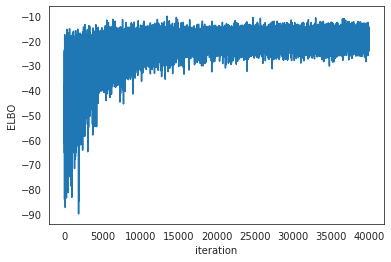

In [12]:
plt.plot(-inference.hist)
plt.ylabel('ELBO')
plt.xlabel('iteration');

#### Plot de los sampleos de los pesos , vemos la cantidad de sampleos que fueron necesarios, a la confianza segun el desvio estandar de las Normales

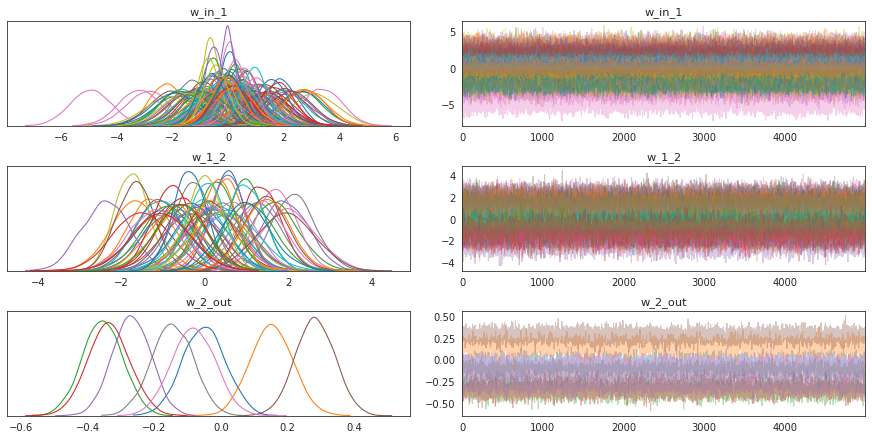

In [12]:
trace = approx.sample(draws=5000)
pm.traceplot(trace);

In [13]:
ann_input.set_value(X_test)
ann_output.set_value(Y_test)

with neural_network:
    ppc = pm.sample_ppc(trace, samples=500, progressbar=False)

# Use probability of > 0.5 to assume prediction of class 1
pred = ppc['out'].mean(axis=0) > 0.2

In [14]:
ppc['out'].shape

(500, 5064)

In [15]:
score_auc = []
score_gan = []
score_accuracy = []
ies = []
for i in np.arange(0, 1, 0.01):
    ies.append(i)
    pred = ppc['out'].mean(axis=0) > i
    ypred = [1 if x == True else 0 for x in pred]
    score_auc.append(roc_auc_score(Y_test, ypred))
    score_accuracy.append(accuracy_score(Y_test, ypred))
    monto_X = list(map(lambda x:x[-2], X_test))
    score_gan.append(custom_loss_calc(monto_X, Y_test, ypred))

In [16]:
ypred = [1 if x == True else 0 for x in pred]

#### Curva de los cortes de la ganancia segun los cortes 

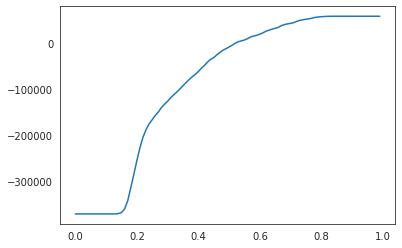

In [18]:
plt.plot(ies, score_gan)
plt.show()

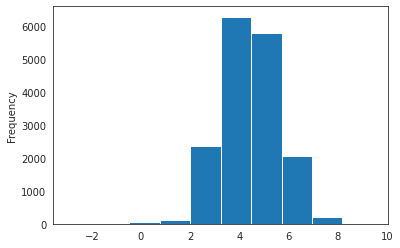

In [21]:
def denorm(val):
    return round(
        (val * np.std(MONTO)) 
        + np.mean(MONTO), 4
        )

pred = ppc['out'].mean(axis=0) > 0.8
ypred = [1 if x == True else 0 for x in pred]

mont_denorm = list(map(lambda x:denorm(x[-2]), X_test))
print("Ganancia del modelo sobre el test {}".format(custom_loss_calc(mont_denorm, Y_test, ypred)))

Ganancia del modelo sobre el test 57525


In [22]:
miss_class = np.where(Y_test != ypred)[0]
corr_class = np.where(Y_test == ypred)[0]

In [25]:
preds = pd.DataFrame(ppc['out']).T
preds.head()

0    1    2    3    4    5    6    7    8    9    ...  490  491  492  493  \
0    1    1    1    1    0    1    1    1    1    1  ...    1    1    1    1   
1    0    1    1    0    1    0    0    1    1    1  ...    1    1    0    1   
2    1    0    1    1    1    0    1    1    1    0  ...    1    0    0    0   
3    0    0    0    0    0    1    0    1    0    1  ...    1    0    0    1   
4    1    0    0    0    0    0    1    0    0    0  ...    0    0    1    0   

   494  495  496  497  498  499  
0    1    1    1    0    1    0  
1    0    0    0    1    0    1  
2    0    0    0    0    0    0  
3    0    0    1    1    0    1  
4    0    0    0    0    0    0  

[5 rows x 500 columns]

In [26]:
chis = preds.apply(lambda x: chisquare(x).statistic, axis='columns')
chis.head()

0    103.0
1    248.0
2    279.0
3    400.0
4    385.0
dtype: float64

#### Plot de los valores del test de chi cuadrado mostrando las regiones de mas certeza y viceversa 

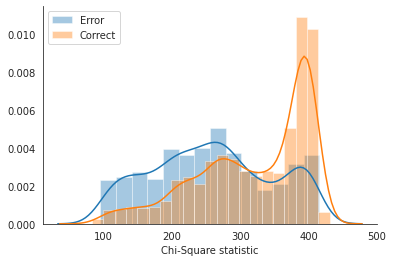

In [102]:
sns.distplot(chis.loc[miss_class].dropna(), label='Error')
sns.distplot(chis.loc[corr_class].dropna(), label='Correct')
plt.legend()
sns.despine()
plt.xlabel('Chi-Square statistic');

#### Accuracy del test

In [35]:
#custom_loss_calc(mont_denorm, Y_test, ypred)
from sklearn.metrics import accuracy_score
round(accuracy_score(Y_test, ypred), 4)

0.718